In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

1195165


In [2]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn

from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive

# Folders

In [3]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.01x'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.01x
-- 1 folders, 225 fovs detected.


In [5]:
# color usage
color_usage_filename = os.path.join(os.path.dirname(data_folder), 'Analysis', 'color_usage_labelX.csv')
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/Analysis/color_usage_labelX.csv


In [6]:
image_infos = color_usage_df.iloc[color_usage_df.get_hyb_id('H0M1')]
print(image_infos)

748      m52
637      m53
545      b24
477    beads
405     DAPI
Name: H0M1, dtype: object


In [7]:
reload(dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [8]:
# load one image
_fov_id = 1
_fov_filename = os.path.join(folders[0], fovs[_fov_id])
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20231012-Merscope01_s40_n500/'
_loading_params ={
    'CorrectionFolder':correction_folder,
}

# load image
daxp = dax_process.DaxProcesser(
    _fov_filename,
    #CorrectionFolder=correction_folder,
    SaveFilename=os.path.join(analysis_folder, fovs[_fov_id].replace('.dax', '.hdf5')),
    FiducialChannel=color_usage_df.get_fiducial_channel(color_usage_df),
    DapiChannel=color_usage_df.get_dapi_channel(color_usage_df),
    **_loading_params,
    )
daxp._load_image()

Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.01x/H0M1/Conv_zscan_001.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.01x/Analysis/Conv_zscan_001.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  40 2304 2304]
- Loaded images for channels:['748', '637', '545', '477', '405'] in 8.578s.


In [9]:
# run correction
_correction_params = {
    'correction_channels':['748', '637'],
    'corr_drift':False,
    'warp_image':True,
}
daxp.RunCorrection(**_correction_params)

- run bleed correction
- Start bleedthrough correction for channels:['748', '637', '545', '477'].
-- loading bleedthrough correction profile from file:bleedthrough_correction_748_637_545_477_2304_2304.npy
-- corrected bleedthrough for channel 748 in 10.492s.
-- corrected bleedthrough for channel 637 in 11.926s.
-- corrected bleedthrough for channel 545 in 11.686s.
-- corrected bleedthrough for channel 477 in 10.602s.
- finish bleedthrough correction in 45.787s. 
- run illumination correction
- Correct illumination for channels: ['748', '637']
-- Keep channels: ['748', '637'] for corr_illumination.
- Start illumination correction for channels:['748', '637'].
-- loading illumination correction profile from file:
	 748 illumination_correction_748_2304x2304.npy
	 637 illumination_correction_637_2304x2304.npy
-- corrected illumination for channel 748 in 5.239s.
-- corrected illumination for channel 637 in 6.272s.
- Finished illumination correction in 12.030s.
- run warp correction
- Start w

In [13]:
_fitting_params = {'channel_2_seeding_kwargs': {'748': {'th_seed': 1000},'637': {'th_seed': 1000}},
                   'fit_channels':['748','637']
                  }

In [14]:
# change fitting param
fitted_spots = daxp._fit_3D_spots(**_fitting_params, overwrite=True)


-- fit spots in channel: 748, - start SpotFitter seeding
-- start seeding image, th=1000.00->1000.00, found 287 seeds in 48.16s
-- start fitting spots with 287 seeds, 287 fitted in 5.266s.
287 fitted in 53.436s.
-- fit spots in channel: 637, - start SpotFitter seeding
-- start seeding image, th=1000.00->1000.00, found 293 seeds in 46.28s
-- start fitting spots with 293 seeds, 293 fitted in 5.245s.
293 fitted in 51.538s.


# visual inspection

<IPython.core.display.Javascript object>


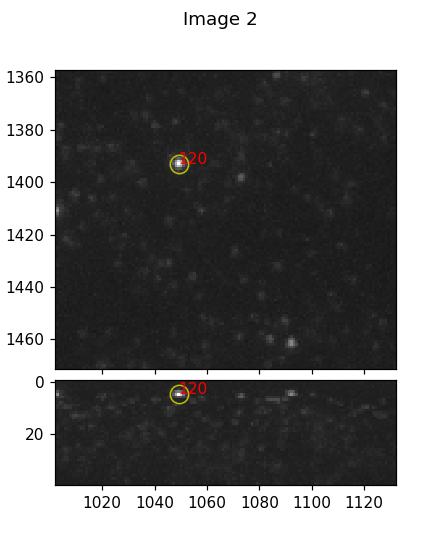

In [15]:
%matplotlib notebook
interactive.imshow_mark_3d([daxp.im_748, daxp.im_637, daxp.im_405], use_dict={
    'class_ids':list(np.zeros(len(daxp.spots_748)))+list(np.ones(len(daxp.spots_637))),
    'coords':list(daxp.spots_748[:,1:4]) + list(daxp.spots_637[:,1:4])}
)

## Iterrate until good fitting is achieved.

# Save merged parameters

In [16]:
# summarize parameter files:
import pickle
merged_parameters = {
    'loading_params': _loading_params,
    'correction_params': _correction_params,
    'fitting_params': _fitting_params,
}
# save
parameter_savefile = os.path.join(analysis_folder, 'H0_preprocessParam.pkl')
print(parameter_savefile)
pickle.dump(merged_parameters, open(parameter_savefile, 'wb'), )

/lab/weissman_imaging/puzheng/PE_LT/20231110-4T1v21x_LabelX_test/0.01x/Analysis/H0_preprocessParam.pkl


In [ ]:
#




# For later rounds, this reference is necessary too:

In [15]:
# load ref_image
_ref_fov_filename = os.path.join(folders[0], fovs[_fov_id])

ref_daxp = dax_process.DaxProcesser(
    _ref_fov_filename,
    CorrectionFolder=correction_folder,
    SaveFilename=os.path.join(analysis_folder, fovs[_fov_id].replace('.dax', '.hdf5')),
    FiducialChannel=color_usage_df.get_fiducial_channel(color_usage_df),
    )
ref_daxp._load_image()

Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20230901-zombie_4T1preEditTop8_low/H0M1/Conv_zscan_01.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20230901-zombie_4T1preEditTop8_low/Analysis/Conv_zscan_01.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  30 2304 2304]
- Loaded images for channels:['748', '637', '545', '477', '405'] in 8.527s.


In [20]:
daxp.RunCorrection(correction_folder=correction_folder, ref_fiducial_image=ref_daxp.im_477)

- run bleed correction
- Correct bleedthrough already finished, skip. 
- run illumination correction
- Correct illumination for channels: ['748', '637', '545', '477']
- Correct illumination already finished, skip. 
- run drift correction
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0. 0. 0.] in 2.537s.
-- drift 1: [0. 0. 0.] in 2.702s.
-- drift 2: [0. 0. 0.] in 2.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- run chromatic correction
- Generate corr_chromatic_functions for channels: ['748', '637', '545']
- Keep channels: ['748', '637', '545'] for corr_chromatic_functions.
- Start generating chromatic correction for channels:['748', '637', '545'].
-- loading chromatic_constants correction profile from file:
	 748 chromatic_correction_748_637_30_2304_2304_const.pkl
	 637 None
	 545 chromatic_correction_545_637_30_2304_2304_const.pkl
-- generate chromatic_shift_function for channel: 748 in 0.0

In [22]:
daxp._fit_3D_spots()

-- fit spots in channel: 748, 

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/lab/weissman_imaging/puzheng/.conda/env/postana

KeyboardInterrupt: 

In [26]:
import warnings
def handle_warning(message, category, filename, lineno, file=None, line=None):
    print('A warning occurred:')
    print(message)
    print('Do you wish to continue?')

    while True:
        response = input('y/n: ').lower()
        if response not in {'y', 'n'}:
            print('Not understood.')
        else:
            break

    if response == 'n':
        raise category(message)
    
def pause_if_warning(function, *args, **kwargs):
    with warnings.catch_warnings(category=RuntimeWarning):
        warnings.showwarning = handle_warning
        return function(*args, **kwargs)

In [35]:
for _channel, _info in image_infos.items():
    with warnings.catch_warnings():
        print(_channel, _info)
        warnings.warn('test', category=RuntimeWarning)

748 r2
637 m53
545 empty
477 beads
405 DAPI


/tmp/ipykernel_1285990/272236076.py:4: RuntimeWarning: test
  warnings.warn('test', category=RuntimeWarning)
/tmp/ipykernel_1285990/272236076.py:4: RuntimeWarning: test
  warnings.warn('test', category=RuntimeWarning)
/tmp/ipykernel_1285990/272236076.py:4: RuntimeWarning: test
  warnings.warn('test', category=RuntimeWarning)
/tmp/ipykernel_1285990/272236076.py:4: RuntimeWarning: test
  warnings.warn('test', category=RuntimeWarning)
/tmp/ipykernel_1285990/272236076.py:4: RuntimeWarning: test
  warnings.warn('test', category=RuntimeWarning)


In [11]:
color_usage_df.get_hyb_id('H0M1')

0

In [12]:
os.listdir(analysis_folder)

['color_usage_v2.csv', 'Color_Usage.csv']